In [1]:
import numpy as np
import multiprocess as mp
from multiprocess import Process
import matplotlib.pyplot as plt

### Section 9.2.1

In [2]:
from causal_gym.envs.mab_cool import MABCOOLPCH
from causal_rl.algo.cool.cool import cool_mab_ucb

def run_ucb_simulation(_):
    mab_env = MABCOOLPCH(delta=0.3)
    do_timesteps = 10000
    ucb_rewards = cool_mab_ucb(mab_env, timesteps=do_timesteps)
    # optimal arm choice is arm 0, with expected reward 0.4
    optimum_rewards = np.ones(do_timesteps)*0.4
    ucb_regret = optimum_rewards - ucb_rewards
    return np.cumsum(ucb_regret)

n_cores = mp.cpu_count()
pool = mp.Pool(processes=n_cores)
all_ucb_regrets = pool.map(run_ucb_simulation, range(1000))
mean_ucb_regret = np.mean(all_ucb_regrets, axis=0)

pool.close()
pool.join()


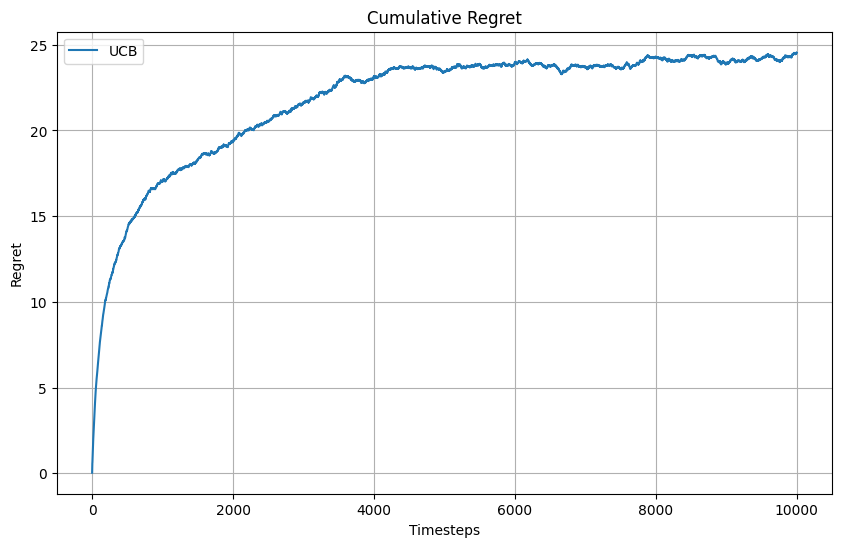

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_ucb_regret)), mean_ucb_regret, label='UCB')
plt.xlabel('Timesteps')
plt.ylabel('Regret')
plt.title('Cumulative Regret')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
from causal_gym.envs.mab_cool import MABCOOLPCH

# collect 5000 observational datapoints to estimate E[Y|x] and P(x)
total_by_arm, reward_by_arm = np.zeros(2), np.zeros(2)
for _ in range(5000):
    mab_env = MABCOOLPCH(delta=0.3)
    _, info = mab_env.reset()
    _, y, terminated, truncated, info = mab_env.see()
    total_by_arm[info['natural_action']] += 1
    reward_by_arm[info['natural_action']] += y
expected_reward_by_arm = reward_by_arm / total_by_arm
prob_of_arm = total_by_arm / 5000

# calculate lower and upper bounds for E[Y|do(x)]
lower_bound = expected_reward_by_arm*prob_of_arm
upper_bound = expected_reward_by_arm*prob_of_arm + (1-prob_of_arm)
print("Lower Bound: ", lower_bound, "Upper Bound: ", upper_bound)

def run_causal_ucb_simulation(_):
    mab_env = MABCOOLPCH(delta=0.3)
    do_timesteps = 10000
    ucb_rewards = cool_mab_ucb(mab_env, lower=lower_bound, upper=upper_bound, timesteps=do_timesteps)
    # optimal arm choice is arm 0, with expected reward 0.4
    optimum_rewards = np.ones(do_timesteps)*0.4
    ucb_regret = optimum_rewards - ucb_rewards
    return np.cumsum(ucb_regret)

n_cores = mp.cpu_count()
pool = mp.Pool(processes=n_cores)
all_causal_ucb_regrets = pool.map(run_causal_ucb_simulation, range(1000))
mean_causal_ucb_regret = np.mean(all_causal_ucb_regrets, axis=0)

pool.close()
pool.join()


Lower Bound:  [0.     0.0998] Upper Bound:  [0.7996 0.3002]


In [6]:
from causal_rl.algo.cool.cool import mab_ucb_direct_transfer

def run_ucb_direct_transfer_simulation(_):
    mab_env = MABCOOLPCH(delta=0.3)
    do_timesteps = 10000
    # match the number of observational datapoints as causal UCB above
    ucb_rewards = mab_ucb_direct_transfer(mab_env, do_timesteps=do_timesteps, see_timesteps=5000)
    # optimal arm choice is arm 0, with expected reward 0.4
    optimum_rewards = np.ones(do_timesteps)*0.4
    ucb_regret = optimum_rewards - ucb_rewards
    return np.cumsum(ucb_regret)

n_cores = mp.cpu_count()
pool = mp.Pool(processes=n_cores)
all_ucb_direct_transfer_regrets = pool.map(run_ucb_direct_transfer_simulation, range(1000))
mean_ucb_direct_transfer_regret = np.mean(all_ucb_direct_transfer_regrets, axis=0)

pool.close()
pool.join()

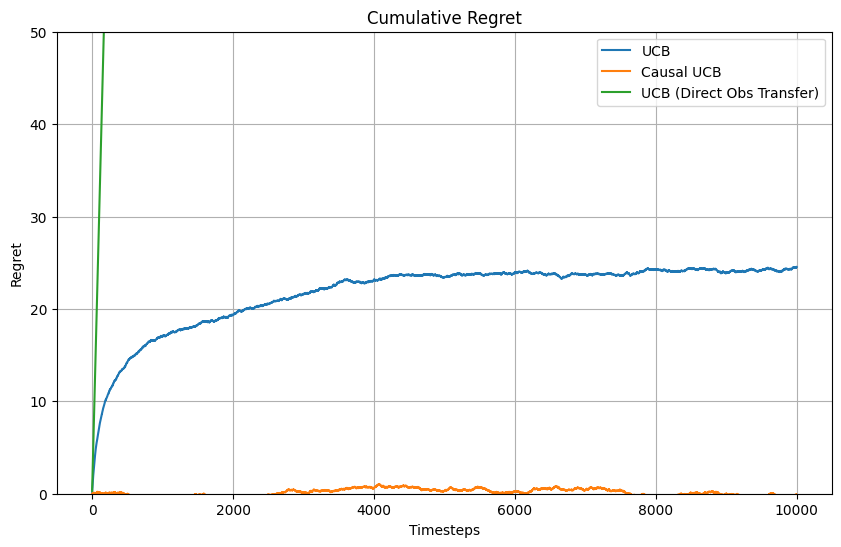

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_ucb_regret)), mean_ucb_regret, label='UCB')
plt.plot(range(len(mean_causal_ucb_regret)), mean_causal_ucb_regret, label='Causal UCB')    
plt.plot(range(len(mean_ucb_direct_transfer_regret)), mean_ucb_direct_transfer_regret, label='UCB (Direct Obs Transfer)')
plt.xlabel('Timesteps')
plt.ylabel('Regret')
plt.title('Cumulative Regret')
plt.grid(True)
plt.legend()
plt.ylim(0, 50)
plt.show()